# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :** 

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation. 

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns 

use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. 

* The remaining samples correspond to $\mathcal{X}$. 

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

In [ ]:
# Ref: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


def Dataloader(batch_size = 10,root_path='./data',num_samples=100, download= True, shuffle_train=True, shuffle_test=False):
  '''
  Dataloader function that keeps only num_samples samples of CIFAR-10 training set
  '''
  train_set = torchvision.datasets.CIFAR10(root=root_path, train=True, download=download, transform=transforms.ToTensor())

  # Keep 100 shuffled examples
  n = np.random.permutation(len(train_set.data))
  train_set.data = train_set.data[n][:num_samples,:,:,:]
  train_set.targets = np.array(train_set.targets)[n][:num_samples]
  train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle=shuffle_train, num_workers=2)

  # Test set
  test_set = torchvision.datasets.CIFAR10(root=root_path, train=False, download=download, transform=transforms.ToTensor())
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=num_samples, shuffle=shuffle_test, num_workers=2)

  return train_set , test_set , train_loader, test_loader

train_set , test_set , train_loader, test_loader = Dataloader()

Files already downloaded and verified
Files already downloaded and verified


## Testing procedure
__Question 2 (1.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

## Answer

Main problem that causes this difficulty is the fact that we have very small training set comparing to test set. Indeed, we have only **100** images out of **50000** images. That will lead to problem of creating wrong represented classes. Secondly, we might have a problem of overfitting.

To tackle this problem, we can select a dataset with reasonable amount of classes. CIFAR-10 is a perfect choice for that. 
Secondly, to handle overfitting, one can consider perform data augmentation and weak supervision techniques.

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. 

## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 25 | 92 | 24 |

In [ ]:
from torchvision.models.resnet import *
import torch.optim as optim

# Block and model are taken from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
# Reference:
#   Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun 
#   Deep Residual Learning for Image Recognition. arXiv:1512.03385

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
# Inspired from https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

def train(model, epochs, optimizer, criterion, train_loader, verbose=True, device=device , start_epoch=0):
  
  model = model.to(device)
  training_loss = []
  training_accuracy = []

  for epoch in range(start_epoch, epochs + start_epoch):
    model.train()

    epoch_train_loss = 0
    total = 0
    correct = 0   

    for _, (inputs, targets) in enumerate(train_loader):

        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)

        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        predicted = output.argmax(dim=1)
        total += len(targets) 
        correct += (predicted == targets).sum()

    epoch_accuracy = 100 * (correct / total )
    training_accuracy.append(epoch_accuracy.item())
    average_epochloss = epoch_train_loss/len(train_loader)
    training_loss.append(average_epochloss)

    if verbose:
      print('Epoch: {} : Loss: {:.4f} / Acc: {:.4f} %'.format(epoch, average_epochloss , epoch_accuracy))
        
  return training_accuracy , training_loss 

In [ ]:
def test (model, criterion, test_loader, device=device, verbose=True):
  model.eval()
  
  with torch.no_grad():

      test_loss = 0
      correct = 0
      total = 0
      
      for _, (inputs, targets) in enumerate(test_loader):

          inputs, targets = inputs.to(device), targets.to(device)
          output = model(inputs)

          loss = criterion(output, targets)
          test_loss += loss.item()

          predicted = output.argmax(dim=1)
          correct += (predicted == targets).sum()
          total += len(targets)

      final_loss = test_loss / len(test_loader)
      final_accuracy = 100 * (correct / total)

      if verbose :
        print('Test Results:  Loss: {} / Acc: {} %'.format(final_loss , final_accuracy ,))
          
  return  final_accuracy

Files already downloaded and verified
Files already downloaded and verified
#######################################
Training
Epoch: 0 : Loss: 2.7874 / Acc: 14.0000 %
Epoch: 1 : Loss: 3.0070 / Acc: 22.0000 %
Epoch: 2 : Loss: 3.0241 / Acc: 24.0000 %
Epoch: 3 : Loss: 2.9293 / Acc: 24.0000 %
Epoch: 4 : Loss: 2.3708 / Acc: 25.0000 %
Epoch: 5 : Loss: 2.4094 / Acc: 25.0000 %
Epoch: 6 : Loss: 2.1453 / Acc: 36.0000 %
Epoch: 7 : Loss: 1.7456 / Acc: 50.0000 %
Epoch: 8 : Loss: 1.6200 / Acc: 47.0000 %
Epoch: 9 : Loss: 1.5094 / Acc: 47.0000 %
Epoch: 10 : Loss: 1.4027 / Acc: 54.0000 %
Epoch: 11 : Loss: 1.1149 / Acc: 59.0000 %
Epoch: 12 : Loss: 1.0211 / Acc: 61.0000 %
Epoch: 13 : Loss: 0.8369 / Acc: 75.0000 %
Epoch: 14 : Loss: 0.6729 / Acc: 85.0000 %
Epoch: 15 : Loss: 0.9880 / Acc: 71.0000 %
Epoch: 16 : Loss: 0.9768 / Acc: 70.0000 %
Epoch: 17 : Loss: 0.8768 / Acc: 74.0000 %
Epoch: 18 : Loss: 0.6369 / Acc: 75.0000 %
Epoch: 19 : Loss: 0.4446 / Acc: 82.0000 %
Epoch: 20 : Loss: 0.5240 / Acc: 83.0000 %
Epo

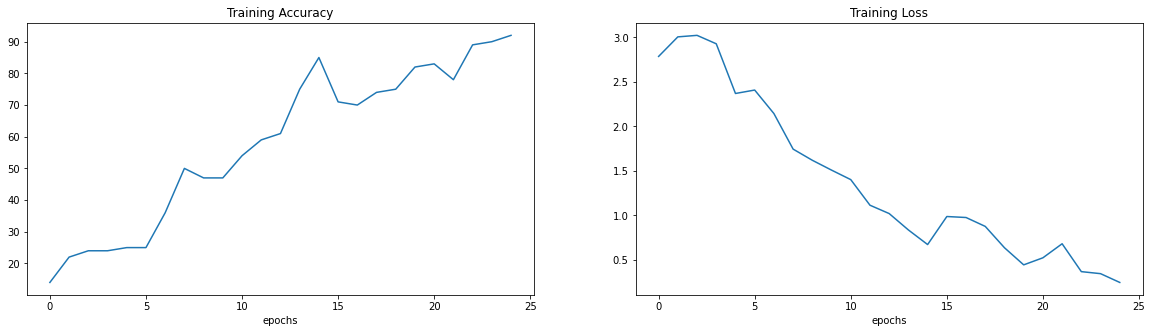

#######################################
Testing
Test Results:  Loss: 4.214362878799438 / Acc: 23.950000762939453 %


In [ ]:
epochs = 25
batch_size = 20

train_set , test_set , train_loader, test_loader = Dataloader()

# Model, Loss criterion, Optimizer
model = ResNet18()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

print("#######################################")
print("Training")
training_accuracy , training_loss = train(model, epochs, optimizer, criterion, train_loader)

fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(np.arange(len(training_accuracy)), training_accuracy)
ax[0].set_title('Training Accuracy')
ax[0].set_xlabel('epochs')

ax[1].plot(np.arange(len(training_loss)), training_loss)
ax[1].set_title('Training Loss')
ax[1].set_xlabel('epochs')

plt.show()

print("#######################################")
print("Testing")
test_accuracy = test(model, criterion, test_loader)

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (3 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet34  | 60 | 96 | 29 |

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1+cu116
Torchvision Version:  0.14.1+cu116


In [ ]:
class resnet34(nn.Module):

    def __init__(self):

        super().__init__()
        self.model = models.resnet34(pretrained=True)

        self.num_filters = self.model.fc.in_features
        self.layers = list(self.model.children())[:-1]
        self.backbone = nn.Sequential(*self.layers)

        # Added layer 
        self.fc1 = nn.Linear(self.num_filters, 64) 
        self.fc = nn.Linear(64, 10)   

    def forward(self, x):

      x = self.backbone(x)
      x = x.squeeze(3)
      x = x.squeeze(2)
      x = self.fc1(x)
      x = self.fc(x)

      return x

In [ ]:
# Hyperparameters
lr = 0.1
batch_size = 8
# Number of epochs
num_epochs = 60

train_set , test_set , train_loader, test_loader = Dataloader(batch_size = batch_size)

# Implementations of code is provided from the official pytorch's documentations; in topics "models and pretrained weights" and "finetuning torchvision models".

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

dataloaders = {'train': train_loader, 'val':test_loader}

# Train hole model or just some layers
feature_extract = False
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Define model
model_ft = resnet34()
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)
input_size = 224

model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, val_acc_history = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 model.conv1.weight
	 model.bn1.weight
	 model.bn1.bias
	 model.layer1.0.conv1.weight
	 model.layer1.0.bn1.weight
	 model.layer1.0.bn1.bias
	 model.layer1.0.conv2.weight
	 model.layer1.0.bn2.weight
	 model.layer1.0.bn2.bias
	 model.layer1.1.conv1.weight
	 model.layer1.1.bn1.weight
	 model.layer1.1.bn1.bias
	 model.layer1.1.conv2.weight
	 model.layer1.1.bn2.weight
	 model.layer1.1.bn2.bias
	 model.layer1.2.conv1.weight
	 model.layer1.2.bn1.weight
	 model.layer1.2.bn1.bias
	 model.layer1.2.conv2.weight
	 model.layer1.2.bn2.weight
	 model.layer1.2.bn2.bias
	 model.layer2.0.conv1.weight
	 model.layer2.0.bn1.weight
	 model.layer2.0.bn1.bias
	 model.layer2.0.conv2.weight
	 model.layer2.0.bn2.weight
	 model.layer2.0.bn2.bias
	 model.layer2.0.downsample.0.weight
	 model.layer2.0.downsample.1.weight
	 model.layer2.0.downsample.1.bias
	 model.layer2.1.conv1.weight
	 model.layer2.1.bn1.weight
	 model.layer2.1.bn1.bias
	 model.layer2.1.conv2.weight
	 model.layer2.1.bn2.weight
	 m

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that :

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

- The problem with small resolution images is that the **transformation** may effect the features. Because of the fact that translated pixels will be replaced by black pixels will lead the loss of information. For example, scaling with a large factor can zoom in the middle of the image, and since we are dealing with a low resolution image, the middle pixels are not representative of the class. To remedy it, one can wrap these pixels around the edges.

- Another problem would be **rotation** as the values of pixels around corner will not correspond to the original grid. One can apply interpolation to solve this problem.


## Data augmentations

__Question 6 (3 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 25 | 87 | 22 |

In [ ]:
# Hyperparameters
batch_size= 64
lr = 0.01

# Data transformations
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(hue=.05, saturation=.05),
                                      transforms.RandomGrayscale(p=0.1),
                                      transforms.RandomRotation(30),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Train dataset
Trainset = torchvision.datasets.CIFAR10(root ="./tdata", download=True, train=True, transform=transform_train)
data= torch.utils.data.Subset(Trainset, list(np.arange(100))) 
train_loader  = torch.utils.data.DataLoader(data, shuffle=True)

# Test dataset
Testset = torchvision.datasets.CIFAR10(root ="./tdata", train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(Testset)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./tdata/cifar-10-python.tar.gz to ./tdata
Files already downloaded and verified


In [ ]:
model = ResNet18()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

model_ft,val_acc_history = train_model(model,dataloaders,criterion,optimizer,25)

fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(np.arange(len(val_acc_history)), val_acc_history)
ax[0].set_title('Training Accuracy')
ax[0].set_xlabel('epochs')


plt.show()


Epoch 0/24
----------
train Loss: 2.8208 Acc: 0.1500
val Loss: 2.7794 Acc: 0.1043

Epoch 1/24
----------
train Loss: 3.2650 Acc: 0.1300
val Loss: 19.5451 Acc: 0.1254

Epoch 2/24
----------
train Loss: 3.2711 Acc: 0.1600
val Loss: 9.4975 Acc: 0.1117

Epoch 3/24
----------
train Loss: 2.7455 Acc: 0.2400
val Loss: 3.8930 Acc: 0.1303

Epoch 4/24
----------
train Loss: 2.6691 Acc: 0.2800
val Loss: 3.5965 Acc: 0.1853

Epoch 5/24
----------
train Loss: 2.1971 Acc: 0.3300
val Loss: 4.2420 Acc: 0.1729

Epoch 6/24
----------
train Loss: 1.9607 Acc: 0.4000
val Loss: 3.0831 Acc: 0.1877

Epoch 7/24
----------
train Loss: 1.6321 Acc: 0.4600
val Loss: 3.6033 Acc: 0.1657

Epoch 8/24
----------
train Loss: 1.8467 Acc: 0.4300
val Loss: 4.7191 Acc: 0.1626

Epoch 9/24
----------
train Loss: 1.6681 Acc: 0.4100
val Loss: 3.2141 Acc: 0.1843

Epoch 10/24
----------
train Loss: 1.1815 Acc: 0.5600
val Loss: 4.0778 Acc: 0.1821

Epoch 11/24
----------
train Loss: 1.4307 Acc: 0.5600
val Loss: 5.6211 Acc: 0.1923

E

In [ ]:
test_accuracy = test(model, criterion, test_loader)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(np.arange(len(val_acc_history)), val_acc_history)
ax[0].set_title('Training Accuracy')
ax[0].set_xlabel('epochs')


plt.show()


# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

In these experiments, we worked on tiny datasets and with different models, we studied the behavior of training procedures of it. 

## Comments on question 3
In this question we are asked to write a classification pipeline for $\mathcal{X}_{train}$  train from scratch and evaluate a **ResNet-18** architecture specific to CIFAR10. 

ResNet18 provides **92% accuracy on training set** and **24% for testing set**. The model is consists of 1 convolutional, 4 connected and 1 linear layers. We trained the model with **25** epochs to get previous results. 

## Comments on question 4

In this case, we selected the model as pretrained **ResNet34** and then we added 2 connected linear layers. After training it with **60 epochs**, we observed that the model provides slightly better accuracy on training set as it gives **96% on training set** and **29% on test set**. We noticed that computional time of training was very high(60 mins for 60 epochs).


## Comments on the impact of Data augmentation

In this method, we used the same architecture as the previous method, but with more data augmentation.

Data augmentation is a method used to improve the training accuracy of a model when dealing with small data sets. Even though we expected to make better results than first implementation by applying it, unfortunately that wasn't the case. We might missed something in the implementation of code. Result was **87% accuracy on training** set and **22% on test set** with **25** epochs.

## Comments on transfer learning
In transfer learning, a machine exploits the knowledge gained from a previous task to improve generalization about another.

Transfer learning provided **best** results(**96% acc. on training set and 29% test set**). this result is expected because the transfer learning framework is specially designed for the case of small data, and we have been able to prove that using it provides better results than training from scratch even if we have a large amount of labelled data. Indeed, its layers are able to extract features that are relevant because network is pretrained with alike images. 

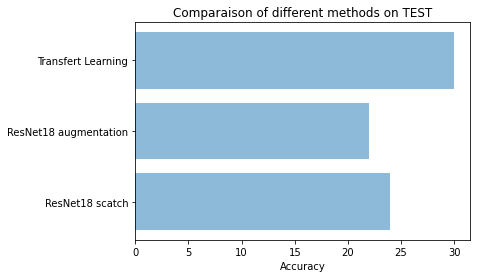

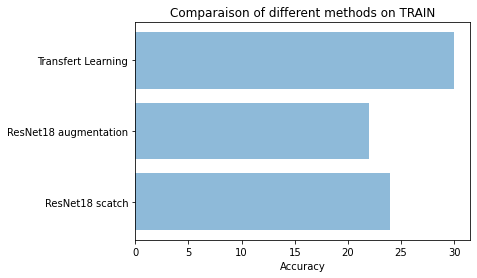

In [ ]:
names = ["ResNet18 scatch", "ResNet18 augmentation", "Transfert Learning"]
test_scores = [24,22,30]

A = np.arange(len(names))
 
plt.barh(A, test_scores, align='center', alpha=0.5)
plt.yticks(A, names)
plt.xlabel('Accuracy')
plt.title('Comparaison of different methods on TEST')
plt.show()

train_scores = [92,87,96]

plt.barh(A, test_scores, align='center', alpha=0.5)
plt.yticks(A, names)
plt.xlabel('Accuracy')
plt.title('Comparaison of different methods on TRAIN')
plt.show()


# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.